# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
#!pip freeze | grep tensorflow

In [2]:
#!pip install tensorflow-gpu==1.3.0
#!pip install tqdm
#!pip install pendulum

In [3]:
#!wget https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip

In [4]:
import pendulum
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm
import cv2
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
from skimage import exposure
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score
%matplotlib inline

In [5]:
training_file = "train.p"
validation_file = "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [18]:
sign_df = pd.read_csv("signnames.csv")

In [19]:
sign_df.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [76]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [9]:
train_df = pd.DataFrame(y_train, columns=['ClassId'])\
.reset_index()\
.merge(sign_df, on=['ClassId'])

In [10]:
fn = lambda obj: obj.loc[np.random.choice(obj.index, size=1, replace=False),['index','ClassId','SignName']]
random_images = train_df\
.groupby('ClassId',as_index=False)\
.apply(fn)

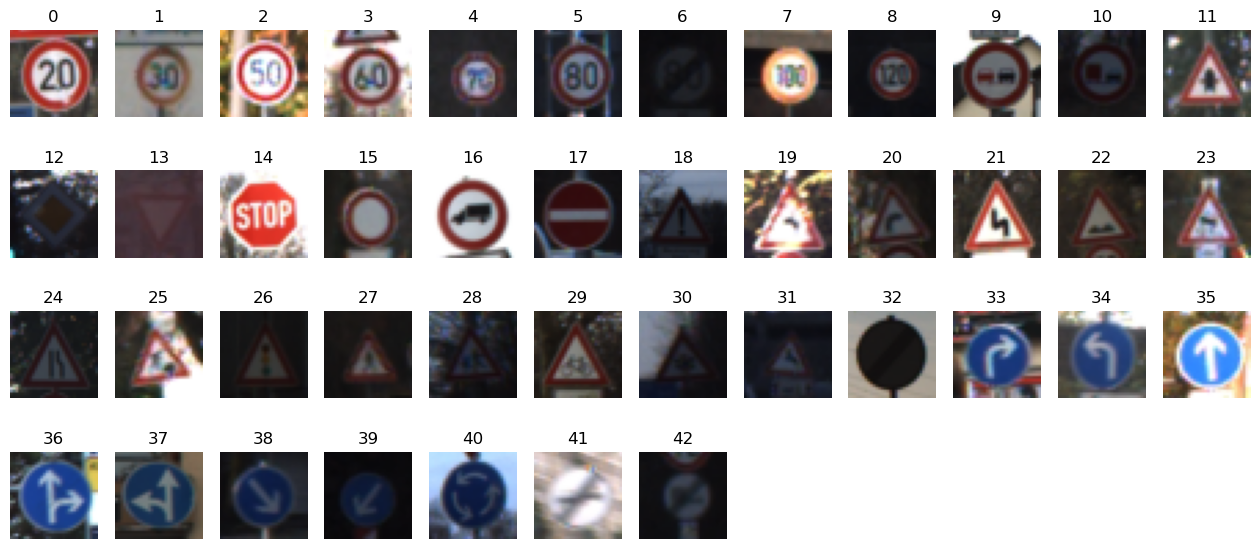

In [11]:
plt.style.use('default')
fig=plt.figure(figsize=(16, 7))
columns = 12
rows = 4
for i in range(len(random_images)):
    fig.add_subplot(rows, columns, i+1)
    ind = random_images.iloc[i]['index']
    plt.imshow(X_train[ind])
    plt.title(y_train[ind])
    plt.axis('off')
plt.show()

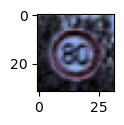

In [58]:
fig=plt.figure(figsize=(1, 1))
plt.imshow(X_train[22025])

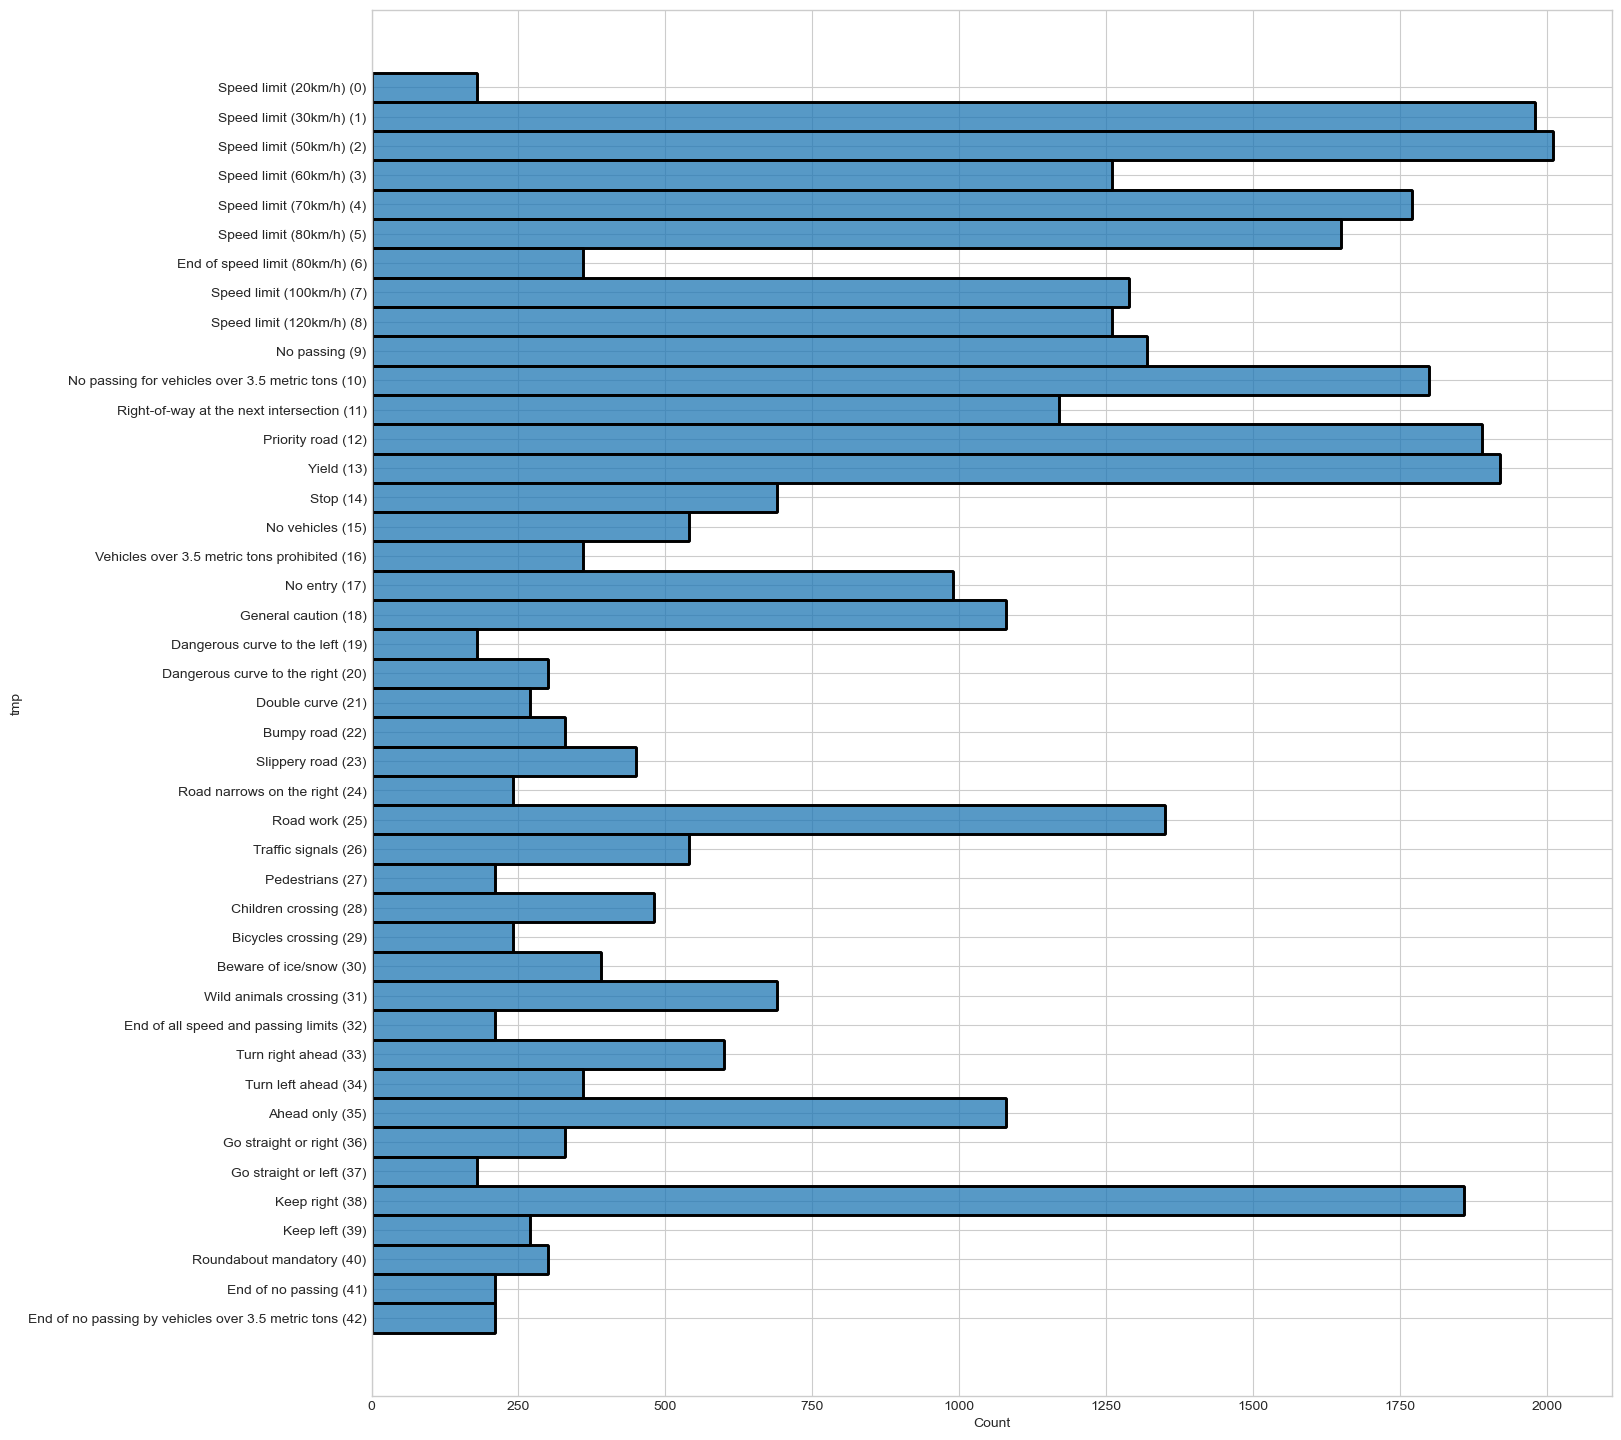

In [12]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(16,18))
train_df['tmp'] = train_df['SignName'] + " (" + train_df['ClassId'].astype("str") + ")"
_ = sns.histplot(data=train_df.sort_values(by='ClassId'), y="tmp")
train_df.drop(columns=['tmp'], inplace=True)

In [51]:
random_images

,,index,ClassId,SignName
0,10100,10100,0,Speed limit (20km/h)
1,2683,2683,1,Speed limit (30km/h)
2,32860,32860,2,Speed limit (50km/h)
3,5856,5856,3,Speed limit (60km/h)
4,8190,8190,4,Speed limit (70km/h)
5,13999,13999,5,Speed limit (80km/h)
6,21764,21764,6,End of speed limit (80km/h)
7,24850,24850,7,Speed limit (100km/h)
8,16067,16067,8,Speed limit (120km/h)
9,12082,12082,9,No passing


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [13]:
image = Image.fromarray(X_train[0])
print(image.format)
print(image.mode)
print(image.size)

None
RGB
(32, 32)


### Normalization

https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html#sphx-glr-auto-examples-color-exposure-plot-equalize-py


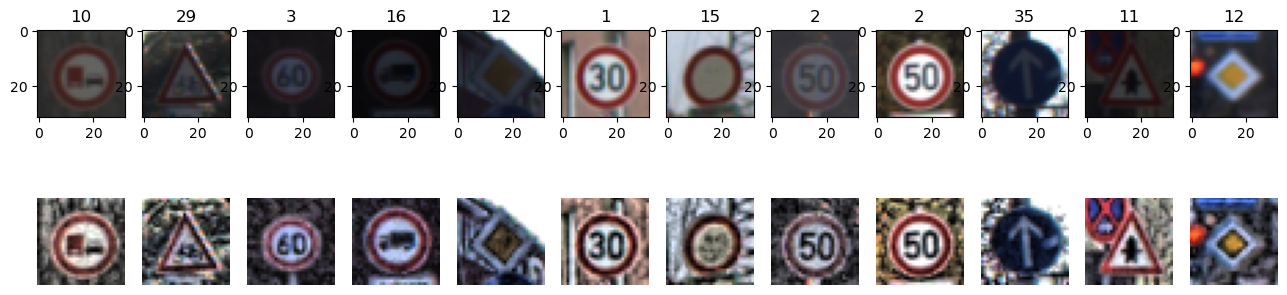

In [14]:
plt.style.use('default')
columns = 12
rows = 2
#rand_ind=np.random.randint(n_train, size=(columns))
rand_ind = np.array([18499, 10638,  5892,  5365, 28314,  3140, 30167, 33105, 31642,
       19797,  9611, 27932])
fig=plt.figure(figsize=(16, 4))
for i,ind in enumerate(rand_ind):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(X_train[ind])
    plt.title(y_train[ind])
    new_image = exposure.equalize_adapthist(X_train[ind], clip_limit=0.1)
    fig.add_subplot(rows, columns, i+columns+1)
    plt.imshow(new_image)
    plt.axis('off')
plt.show()

In [1]:
def preprocess(images):
    
    def normalize(image):
        return exposure.equalize_adapthist(image, clip_limit=0.1)
    new_images = []  
    pbar = tqdm(total=len(images))
    for i in range(len(images)):
        new_images.append(normalize(images[i]))
        pbar.update(1)
    return np.array(new_images)

In [16]:
X_train = preprocess(X_train)

In [17]:
X_valid = preprocess(X_valid)

In [18]:
X_test = preprocess(X_test)

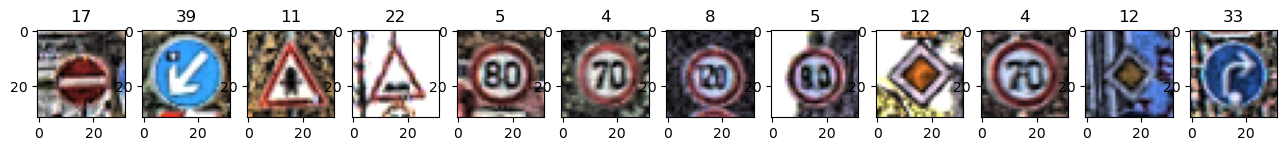

In [19]:
# Visual check the preprocessing work correctly
plt.style.use('default')
columns = 12
rows = 2
rand_ind=np.random.randint(n_train, size=(columns))
fig=plt.figure(figsize=(16, 4))
for i,ind in enumerate(rand_ind):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(X_train[ind])
    plt.title(y_train[ind])
plt.show()

### Model Architecture

In [11]:
### Define your architecture here.
def create_model(x):    
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    # filter height and width
    # # (height, width, input_depth, output_depth)
    w = tf.Variable(tf.random_normal([5, 5, 3, 6], mean = mu, stddev = sigma))
    # depth
    b = tf.Variable(tf.random_normal([6]))
    # strides first 1 and last 1
    strides = [1, 1, 1, 1]
    padding = 'VALID'
    conv1 = tf.nn.conv2d(x, w, strides, padding) + b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    
    # Layer 2: Convolutional. Input 28x28x6, Output = 14x14x6.
    # # (height, width, input_depth, output_depth)
    w = tf.Variable(tf.random_normal([2, 2, 6, 6], mean = mu, stddev = sigma))
    # output depth
    b = tf.Variable(tf.random_normal([6]))
    strides = [1, 2, 2, 1]
    padding = 'VALID'
    conv2 = tf.nn.conv2d(conv1, w, strides, padding) + b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Layer 3: Convolutional. Input 14x14x6, Output = 10x10x16.
    w = tf.Variable(tf.random_normal([5, 5, 6, 16], mean = mu, stddev = sigma))
    # output depth
    b = tf.Variable(tf.random_normal([16]))
    strides = [1, 1, 1, 1]
    padding = 'VALID'
    conv3 = tf.nn.conv2d(conv2, w, strides, padding) + b
    
    # Activation.
    conv3 = tf.nn.relu(conv3)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    ksize = [1, 2, 2, 1]
    # (batch_size, height, width, depth)
    strides = [1, 2, 2, 1]
    padding = 'VALID'
    poolx =  tf.nn.max_pool(conv3, ksize, strides, padding)

    # Flatten. Input = 5x5x16. Output = 400.
    flatx   = flatten(poolx)
    # ValueError: Dimensions must be equal, but are 294 and 400 for 'MatMul_49' (op: 'MatMul') 
    # with input shapes: [?,294], [400,120]
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    # Wx + b
    # (1,400) . (400,120) = (1,120)
    w = tf.Variable(tf.random_normal([400,120], mean = mu, stddev = sigma))
    b = tf.Variable(tf.random_normal([120]))
    fc_1 = tf.add(tf.matmul(flatx,w),b)
    
    # Activation.
    fc_1 = tf.nn.relu(fc_1)
    
    # Dropout 
    fc_1 = tf.nn.dropout(fc_1, keep_prob)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    # (1,120) . (120,84) = (1,84)
    w = tf.Variable(tf.random_normal([120,84], mean = mu, stddev = sigma))
    b = tf.Variable(tf.random_normal([84]))
    fc_2 = tf.add(tf.matmul(fc_1,w),b)
    
    # Activation.
    fc_2 = tf.nn.relu(fc_2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    # (1,84) . (84,43) = (1,43)
    w = tf.Variable(tf.random_normal([84,43], mean = mu, stddev = sigma))
    b = tf.Variable(tf.random_normal([43]))
    logits = tf.add(tf.matmul(fc_2,w),b)
    
    return logits

In [12]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32) 

#### Learning Rate Decay

$\eta(s) = \frac{\eta_{0}}{(1+s.\eta_{d})}$

In [13]:
# https://ireneli.eu/2016/03/13/tensorflow-04-implement-a-lenet-5-like-nn-to-classify-notmnist-images/
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.001
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
100000, 0.96, staircase=True)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [14]:
EPOCHS = 50
BATCH_SIZE = 128
#learning_rate = 0.001
logits = create_model(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)

In [15]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy,loss = sess.run([accuracy_operation,loss_operation], feed_dict={x: batch_x, y: batch_y,keep_prob:1})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return total_accuracy / num_examples, total_loss / num_examples

In [25]:
metrics = []
start = pendulum.now()
sessions = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        pbar = tqdm(total=np.ceil(num_examples/BATCH_SIZE))
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:0.5})
            pbar.update(1)
            
        train_acc, train_loss = evaluate(X_train, y_train)
        val_acc, val_loss = evaluate(X_valid, y_valid)
        metrics.append({
            'train_acc':train_acc,
            'train_loss': train_loss,
            'val_acc':val_acc,
            'val_loss': val_loss
        })
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.3f} Validation Accuracy = {:.3f}"\
              .format(train_acc,val_acc))
        
        # store the sessions into list
        sessions.append(sess)
        
    saver.save(sess, 'model/traffic_sign')
    print("Model saved")
end = pendulum.now()

Training...


EPOCH 1 ...
Train Accuracy = 0.563 Validation Accuracy = 0.516


EPOCH 2 ...
Train Accuracy = 0.853 Validation Accuracy = 0.821



EPOCH 3 ...
Train Accuracy = 0.918 Validation Accuracy = 0.888


EPOCH 4 ...
Train Accuracy = 0.947 Validation Accuracy = 0.912


EPOCH 5 ...
Train Accuracy = 0.954 Validation Accuracy = 0.920




EPOCH 6 ...
Train Accuracy = 0.967 Validation Accuracy = 0.925


EPOCH 7 ...
Train Accuracy = 0.971 Validation Accuracy = 0.929


EPOCH 8 ...
Train Accuracy = 0.976 Validation Accuracy = 0.942



EPOCH 9 ...
Train Accuracy = 0.978 Validation Accuracy = 0.940


EPOCH 10 ...
Train Accuracy = 0.984 Validation Accuracy = 0.951


EPOCH 11 ...
Train Accuracy = 0.982 Validation Accuracy = 0.945



EPOCH 12 ...
Train Accuracy = 0.987 Validation Accuracy = 0.949


EPOCH 13 ...
Train Accuracy = 0.984 Validation Accuracy = 0.947


EPOCH 14 ...
Train Accuracy = 0.988 Validation Accuracy = 0.945




EPOCH 15 ...
Train Accuracy = 0.989 Validation Accuracy = 0.943


EPOCH 16 ...
Train Accuracy = 0.991 Validation Accuracy = 0.948


EPOCH 17 ...
Train Accuracy = 0.990 Validation Accuracy = 0.949



EPOCH 18 ...
Train Accuracy = 0.992 Validation Accuracy = 0.951


EPOCH 19 ...
Train Accuracy = 0.991 Validation Accuracy = 0.951


EPOCH 20 ...
Train Accuracy = 0.992 Validation Accuracy = 0.949



EPOCH 21 ...
Train Accuracy = 0.990 Validation Accuracy = 0.949


EPOCH 22 ...
Train Accuracy = 0.993 Validation Accuracy = 0.946


EPOCH 23 ...
Train Accuracy = 0.994 Validation Accuracy = 0.957



EPOCH 24 ...
Train Accuracy = 0.995 Validation Accuracy = 0.953


EPOCH 25 ...
Train Accuracy = 0.995 Validation Accuracy = 0.953


EPOCH 26 ...
Train Accuracy = 0.997 Validation Accuracy = 0.956



EPOCH 27 ...
Train Accuracy = 0.994 Validation Accuracy = 0.954


EPOCH 28 ...
Train Accuracy = 0.996 Validation Accuracy = 0.956


EPOCH 29 ...
Train Accuracy = 0.996 Validation Accuracy = 0.956



EPOCH 30 ...
Train Accuracy = 0.997 Validation Accuracy = 0.967


EPOCH 31 ...
Train Accuracy = 0.994 Validation Accuracy = 0.954


EPOCH 32 ...
Train Accuracy = 0.997 Validation Accuracy = 0.955





















EPOCH 33 ...
Train Accuracy = 0.997 Validation Accuracy = 0.954


EPOCH 34 ...
Train Accuracy = 0.997 Validation Accuracy = 0.958


EPOCH 35 ...
Train Accuracy = 0.998 Validation Accuracy = 0.960


EPOCH 36 ...
Train Accuracy = 0.997 Validation Accuracy = 0.961




EPOCH 37 ...
Train Accuracy = 0.998 Validation Accuracy = 0.956


EPOCH 38 ...
Train Accuracy = 0.998 Validation Accuracy = 0.956


EPOCH 39 ...
Train Accuracy = 0.996 Validation Accuracy = 0.951



EPOCH 40 ...
Train Accuracy = 0.998 Validation Accuracy = 0.952


EPOCH 41 ...
Train Accuracy = 0.998 Validation Accuracy = 0.962


EPOCH 42 ...
Train Accuracy = 0.998 Validation Accuracy = 0.953



EPOCH 43 ...
Train Accuracy = 0.999 Validation Accuracy = 0.962


EPOCH 44 ...
Train Accuracy = 0.998 Validation Accuracy = 0.971


EPOCH 45 ...
Train Accuracy = 0.998 Validation Accuracy = 0.961



EPOCH 46 ...
Train Accuracy = 0.998 Validation Accuracy = 0.952


EPOCH 47 ...
Train Accuracy = 0.998 Validation Accuracy = 0.956


EPOCH 48 ...
Train Accuracy = 0.999 Validation Accuracy = 0.966



EPOCH 49 ...
Train Accuracy = 0.999 Validation Accuracy = 0.969


EPOCH 50 ...
Train Accuracy = 0.999 Validation Accuracy = 0.969
Model saved


In [26]:
print("Total training time",(end-start).in_words())

Total training time 26 minutes 29 seconds


In [70]:
print("Final Validation Accuracy", metrics[-1]['val_acc']*100, "%")

Final Validation Accuracy 96.91609980027421 %


In [27]:
metric_df = pd.DataFrame(metrics)

In [28]:
sessions[0]

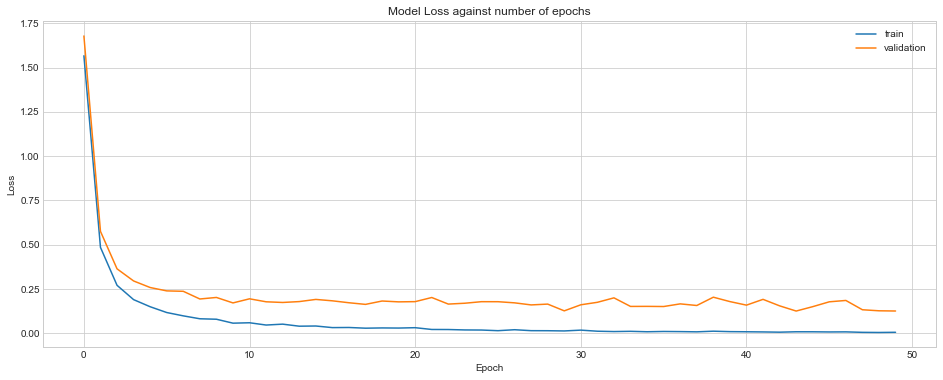

In [71]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(16,6))
plt.plot(metric_df['train_loss'], label='train')
plt.plot(metric_df['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss against number of epochs')
plt.legend()
plt.show()

In [74]:
metric_df[metric_df['val_acc']>=0.93].head()

,train_acc,train_loss,val_acc,val_loss
7,0.976264,0.081489,0.942404,0.193210
8,0.977930,0.078874,0.940136,0.201879
9,0.984310,0.056636,0.950794,0.171001
10,0.982327,0.058947,0.944671,0.194226
11,0.987126,0.046077,0.949433,0.177359


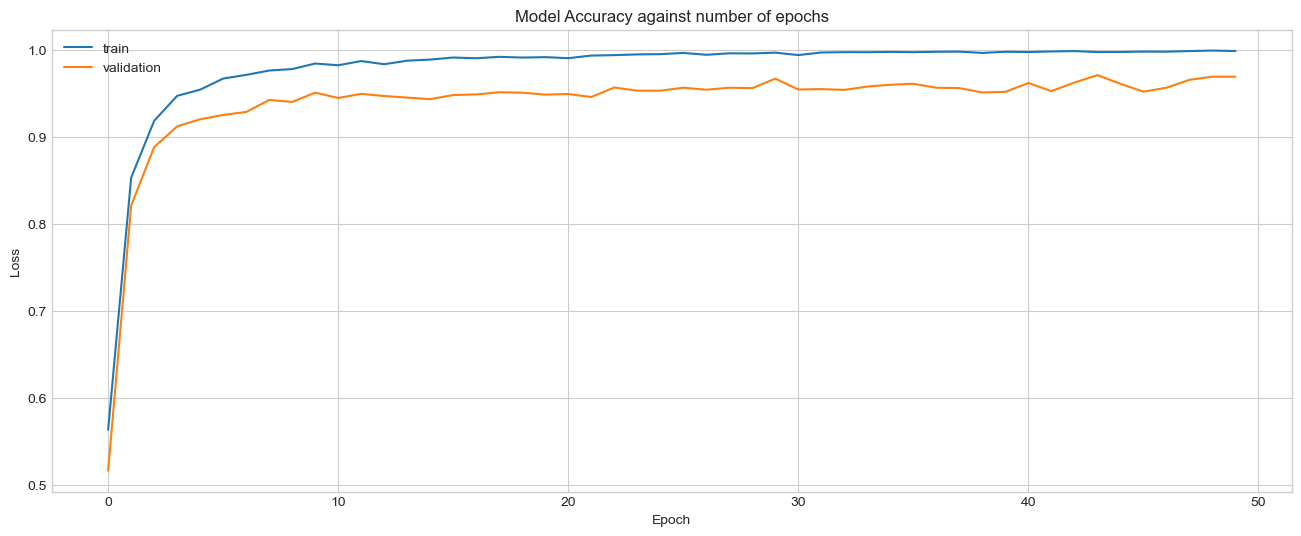

In [31]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(16,6))
plt.plot(metric_df['train_acc'], label='train')
plt.plot(metric_df['val_acc'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Accuracy against number of epochs')
plt.legend()
plt.show()

In [9]:
def predict(X, n=5, mode_dir='model'):
    """
    Predict the data
    return the predicted class and probability
    i.e: top_k.indices[0][0], top_k.values[0][0]
    is the predicted class with its probability
    """
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, tf.train.latest_checkpoint(mode_dir))
        #softmax = sess.run(tf.nn.softmax(logits), feed_dict={x: X, keep_prob: 1.0})
        top_k = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=n), feed_dict={x: X, keep_prob: 1.0})
        return top_k

In [33]:
pred = predict(X_test, n=1)

INFO:tensorflow:Restoring parameters from model/traffic_sign


In [34]:
test_df = pd.DataFrame(y_test, columns=['ClassId'])\
.reset_index()\
.merge(sign_df, on=['ClassId'])\
.sort_values(by='index')\
.reset_index(drop=True)

In [35]:
test_df['predicted'] = pred.indices

In [36]:
precision, recall, fscore, support = score(test_df['ClassId'], test_df['predicted'])
score_df = sign_df.copy()
score_df['precision'] = precision
score_df['recall'] = recall
score_df['fscore'] = fscore
score_df['support'] = support

In [37]:
score_df

,ClassId,SignName,precision,recall,fscore,support
0,0,Speed limit (20km/h),0.965517,0.933333,0.949153,60
1,1,Speed limit (30km/h),0.933784,0.959722,0.946575,720
2,2,Speed limit (50km/h),0.952073,0.980000,0.965834,750
3,3,Speed limit (60km/h),0.914474,0.926667,0.920530,450
4,4,Speed limit (70km/h),0.992076,0.948485,0.969791,660
5,5,Speed limit (80km/h),0.898021,0.936508,0.916861,630
6,6,End of speed limit (80km/h),0.976562,0.833333,0.899281,150
7,7,Speed limit (100km/h),0.927350,0.964444,0.945534,450
8,8,Speed limit (120km/h),0.968900,0.900000,0.933180,450
9,9,No passing,0.969512,0.993750,0.981481,480


In [38]:
print("Test Accuracy",accuracy_score(test_df['ClassId'] , test_df['predicted'] ))

Test Accuracy 0.9441013460015836


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [39]:
# Images were taken from these websites
# https://www.alamy.com 
# https://www.rgbstock.coma

In [30]:
import os
from skimage import transform
test_folder = "test_images"
y = np.zeros((5,1))
X = np.zeros((5,32,32,3))
i = 0
for file in os.listdir(test_folder):
    fsplit = file.split(".")
    if fsplit[1] == "jpg":
        label = int(fsplit[0])
        image = mpimg.imread(os.path.join(test_folder,file))
        image = transform.resize(image, (32, 32))
        y[i] = label
        X[i] = image
        i += 1

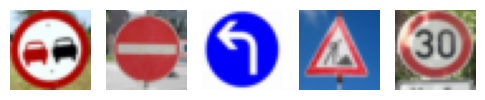

In [35]:
plt.style.use('default')
columns = 5
rows = 1
fig=plt.figure(figsize=(6, 4))
for i in range(len(X)):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(X[i])
    #plt.title(y_train[ind])
    plt.axis('off')
plt.show()

In [23]:
X = preprocess(X)

### Predict the Sign Type for Each Image

In [24]:
test_pred = predict(X,n=1)

INFO:tensorflow:Restoring parameters from model/traffic_sign


### Analyze Performance

In [26]:
real_df = pd.DataFrame(y, columns=['ClassId'])\
.reset_index()\
.merge(sign_df, on=['ClassId'])\
.sort_values(by='index')\
.reset_index(drop=True)

In [27]:
real_df['predicted'] = test_pred.indices

In [28]:
real_df[['SignName','ClassId','predicted']]

,SignName,ClassId,predicted
0,No passing,9.0,9
1,No entry,17.0,17
2,Turn left ahead,34.0,38
3,Road work,25.0,23
4,Speed limit (30km/h),1.0,9


In [29]:
print("Google image Accuracy",accuracy_score(real_df['ClassId'] , real_df['predicted'] )*100,"%")

Google image Accuracy 40.0 %


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [47]:
# Get the top 5 probabilities
test_pred = predict(X,n=5)

INFO:tensorflow:Restoring parameters from model/traffic_sign


In [48]:
test_pred

TopKV2(values=array([[5.20937085e-01, 4.30374593e-01, 3.65119241e-02, 8.19845311e-03,
        3.92265059e-03],
       [1.00000000e+00, 2.82791568e-10, 2.55621774e-10, 8.72714834e-12,
        5.34425022e-12],
       [9.97047722e-01, 2.95130047e-03, 4.86158115e-07, 2.30711663e-07,
        2.19289177e-07],
       [4.48250055e-01, 3.93270463e-01, 1.58079445e-01, 1.40255725e-04,
        1.39694253e-04],
       [3.51559222e-01, 1.17177114e-01, 1.06210381e-01, 8.36023316e-02,
        6.17451183e-02]], dtype=float32), indices=array([[ 9, 16, 41, 42, 10],
       [17,  9,  0, 14,  1],
       [38, 34, 35, 37, 36],
       [23, 20, 25, 10, 19],
       [ 9, 19, 16,  1,  0]], dtype=int32))

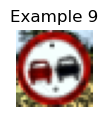

Top 5 Predicted Class and Probability


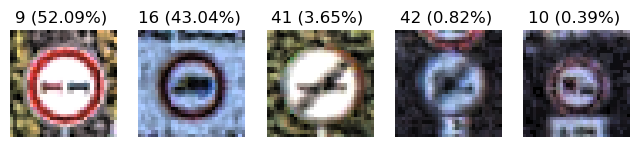

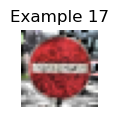

Top 5 Predicted Class and Probability


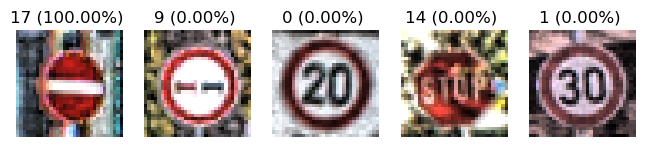

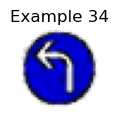

Top 5 Predicted Class and Probability


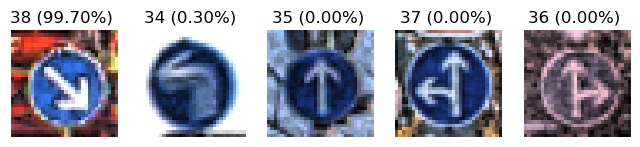

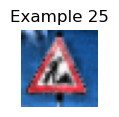

Top 5 Predicted Class and Probability


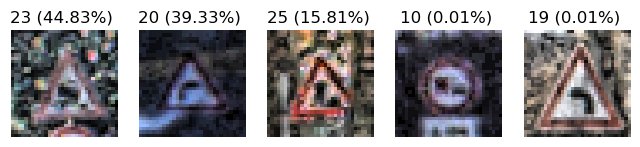

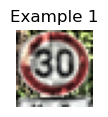

Top 5 Predicted Class and Probability


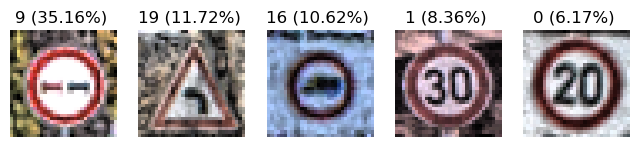

In [72]:
train_df = pd.DataFrame(y_train, columns=['ClassId'])\
.reset_index()\
.merge(sign_df, on=['ClassId'])

fn = lambda obj: obj.loc[np.random.choice(obj.index, size=1, replace=False),['index','ClassId','SignName']]
random_images = train_df\
.groupby('ClassId',as_index=False)\
.apply(fn)

for index in range(5):
    plt.style.use('default')
    columns = 5
    rows = 1
    plt.figure(figsize=(2, 1))
    plt.imshow(X[index])
    title = "Example {0:.0f}".format(y[index][0])
    plt.axis('off')
    plt.title(title)
    plt.show()
    fig=plt.figure(figsize=(8, 4))
    print("Top 5 Predicted Class and Probability")
    for i,class_id in enumerate(test_pred.indices[index]):
        ind = random_images[random_images['ClassId']==class_id].iloc[0]['index']
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(X_train[ind])
        title = "{0} ({1:.2f}%) ".format(class_id,test_pred.values[index][i]*100)
        plt.axis('off')
        plt.title(title)
    plt.show()

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [50]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")